# 📈 <span style="color:#086591; text-decoration: underline;">Partie Modélisation</span>


Maintenant nous sommes arrivés à la partie de modélisation.
Nous cherchons à expliquer les retards grâce à des variables explicatives. Dans un premier temps, nous allons modéliser le jeu de données existant en adoptant la régression logistique suivie dela méthode Random Forest . Puis, nous nous intéresserons à la comparaison des performances entre ces deux méthodes.

#### Le choix de méthode ###
Nous avons choisi la régression logistique et Random forest car nous sommes face à un problème  de classification binaire où la variable cible "Retard" prend deux valeurs : 0 (pas de retard) et 1 (retard).

### 🧠 <span style="text-decoration: underline;">**Régression Logistique :**

un problème de classification binaire de manière linéaire, c’est-à-dire modéliser y £ {0,1}  à l’aide d’une combinaison linéaire de variables.


In [295]:
#bibliothèques
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, roc_curve, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, chi2
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

In [296]:
data = pd.read_csv("data.csv")
data.columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50697 entries, 0 to 50696
Data columns (total 31 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      50697 non-null  object 
 1   Destination Airport                       50697 non-null  object 
 2   Scheduled departure time                  50697 non-null  object 
 3   Actual departure time                     50697 non-null  object 
 4   Wheels-off time                           50697 non-null  object 
 5   Taxi-Out time (Minutes)                   50697 non-null  float64
 6   Delay Carrier (Minutes)                   50697 non-null  float64
 7   Delay Weather (Minutes)                   50697 non-null  float64
 8   Delay National Aviation System (Minutes)  50697 non-null  float64
 9   Delay Security (Minutes)                  50697 non-null  float64
 10  Delay Late Aircraft Arrival (Minut

Je vais laisser que des variables qui peuvent avoir un effet c'est-à-dire je vais supprimer les variables indésirables , comme time date ... etc.

In [297]:
df = data.drop('time', axis=1)
colu= ["Season","Period_Day","Weekday_Flight","Destination Airport","Date","Scheduled departure time","Actual departure time","Wheels-off time"]
df = df.drop(columns=colu)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50697 entries, 0 to 50696
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Taxi-Out time (Minutes)                   50697 non-null  float64
 1   Delay Carrier (Minutes)                   50697 non-null  float64
 2   Delay Weather (Minutes)                   50697 non-null  float64
 3   Delay National Aviation System (Minutes)  50697 non-null  float64
 4   Delay Security (Minutes)                  50697 non-null  float64
 5   Delay Late Aircraft Arrival (Minutes)     50697 non-null  float64
 6   Retard                                    50697 non-null  int64  
 7   Weekday_Flight_encoded                    50697 non-null  int64  
 8   Season_encoded                            50697 non-null  int64  
 9   Period_Day_encoded                        50697 non-null  int64  
 10  Destination_encoded               

Le pre-processing est un Standard Scaler permettant de standardiser les données.

L'approche Train-Test Split consiste à décomposer de manière aléatoire notre données. Une partie servira à l’entraînement du modèle (training) et on réserve 70% à 80% des données du dataset pour l’entraînement, l’autre partie permettra de le tester pour la validation.

In [298]:
# Normalisation des colonnes numériques
scaler = MinMaxScaler()
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Division aléatoire en ensembles d'apprentissage et de test
seed = 131
train_set, test_set = train_test_split(df, test_size=0.2, random_state=seed)


In [299]:
train_set['Retard'].value_counts(normalize=True)*100

Retard
0.0    68.138669
1.0    31.861331
Name: proportion, dtype: float64

# **Le problème de déséquilibre de classes  Class  | Imbalance Problem**

pour résoudre ce type des problèmes on utilise la méthode du rééchantillonnage des données .

le rééchantillonnage des données : 

- **Random Under Sampling  RUS , sous échantillonement de la classe majoritaire:**

consiste à tirer au hasard des observations de cas de non-defaut pour correspondre au nombre d’observations de cas de defaut de paiement . 

Le RUS vise à réduire le déséquilibre en diminuant la taille de la classe majoritaire. Cela se fait en supprimant aléatoirement des observations de la classe majoritaire jusqu'à ce que le nombre d'observations dans cette classe corresponde approximativement à celui de la classe minoritaire

une perte massive d’informations potentiellement importantes

- **Random Over Sampling  ROS , sur échantillonement de la classe minoritaire:**

consiste à effectuer des tirages aléatoires d’observations de cas de défaut et dupliquer ces observations afin de correspondre au nbre de cas de non-défaut.

vise à augmenter la taille de la classe minoritaire en dupliquant des observations de cette classe ou en générant de nouvelles observations synthétiques

on peut avoir un surapprentissage (overfitting)

- **Synthetic Minority Oversampling Technique ou SMOTE**

SMOTE génère de nouvelles observations synthétiques en se basant sur les caractéristiques des observations existantes.

1. **Sélection d'une observation :**
SMOTE commence par choisir aléatoirement une observation de la classe minoritaire.
2. **Trouver les voisins les plus proches :**
SMOTE identifie les k voisins les plus proches de cette observation dans la classe minoritaire (k étant généralement un paramètre défini par l'utilisateur). Ces voisins sont trouvés dans l'espace des caractéristiques, souvent à l'aide d'une métrique de distance comme la distance euclidienne.

In [300]:
# Sous-échantillonnage
rus = RandomUnderSampler(random_state=seed)
train_undersampled, train_undersampled_labels = rus.fit_resample(train_set.drop('Retard', axis=1),
                                                                 train_set['Retard'])
print(type(train_undersampled))
print(train_undersampled.describe())

# Sur-échantillonnage
ros = RandomOverSampler(random_state=seed)
train_oversampled, train_oversampled_labels = ros.fit_resample(train_set.drop('Retard', axis=1),
                                                               train_set['Retard'])


<class 'pandas.core.frame.DataFrame'>
       Taxi-Out time (Minutes)  Delay Carrier (Minutes)  \
count             25844.000000             25844.000000   
mean                  0.137334                 0.004738   
std                   0.072377                 0.025319   
min                   0.000000                 0.000000   
25%                   0.096045                 0.000000   
50%                   0.118644                 0.000000   
75%                   0.152542                 0.000000   
max                   0.926554                 1.000000   

       Delay Weather (Minutes)  Delay National Aviation System (Minutes)  \
count             25844.000000                              25844.000000   
mean                  0.000852                                  0.003953   
std                   0.012844                                  0.015173   
min                   0.000000                                  0.000000   
25%                   0.000000                    

In [301]:
# Taille avant sur-échantillonnage
print(train_set['Retard'].value_counts())

# Taille après sur-échantillonnage
oversampled_df = pd.DataFrame(train_oversampled, columns=train_set.drop('Retard', axis=1).columns)
oversampled_df['Retard'] = train_oversampled_labels
print(oversampled_df['Retard'].value_counts())

# Taille après sous-échantillonnage
train_undersampled_df = pd.DataFrame(train_undersampled, columns=train_set.drop('Retard', axis=1).columns)
train_undersampled_df['Retard'] = train_undersampled_labels
print(train_undersampled_df['Retard'].value_counts())



Retard
0.0    27635
1.0    12922
Name: count, dtype: int64
Retard
1.0    27635
0.0    27635
Name: count, dtype: int64
Retard
0.0    12922
1.0    12922
Name: count, dtype: int64


# Création du modèle. 
Nous avons choisi le sur-échantillonnage car  on voit bien  une différence significative entre les classes 27,635 contre 12,922.
le sur-échantillonnage est  préférable dans ce cas , car il permet de conserver la totalité  des données de la classe majoritaire (classe 1).

Nous avons  effectué une analyse approfondie des coefficients, de leur significativité statistique, ainsi que de la corrélation de Pearson entre les variables explicatives et la variable cible "Retard".



In [302]:
# Modèle de régression logistique
x_train = train_oversampled
y_train = train_oversampled_labels
clf = LogisticRegression()
clf.fit(x_train, y_train)

# Coefficients du modèle
coefficients = clf.coef_[0]
intercept = clf.intercept_[0]
coeff_df = pd.DataFrame({'Variable': x_train.columns, 'Coefficient': coefficients})
coeff_df.loc[len(coeff_df)] = ['Intercept', intercept]
print(coeff_df)

# Calcul des statistiques
n = len(y_train)
p = x_train.shape[1]
X = np.hstack((np.ones((n, 1)), x_train))
y_pred = clf.predict(x_train)
residus = y_train - y_pred
sigma_hat = np.sqrt(np.sum(residus ** 2) / (n - p))
var_cov_beta = np.linalg.inv(X.T @ X) * sigma_hat ** 2
std_err_beta = np.sqrt(np.diag(var_cov_beta))

# Variables significatives
alpha = 0.1
z_score = clf.coef_ / std_err_beta[1:]
p_values = 2 * (1 - chi2.cdf(z_score ** 2, 1))
significant_vars = x_train.columns[np.array(p_values).reshape(-1) < alpha]
print("Variables significatives :", significant_vars)

# Modèle réduit aux variables significatives
significant_coefs = clf.coef_[0][np.isin(x_train.columns, significant_vars)]
significant_model = pd.DataFrame({'Variable': significant_vars, 'Coefficient': significant_coefs})
print("Modèle significatif :\n", significant_model)

# Corrélation de Pearson
pearson_correlation = []
pearson_p_value = []
for var in x_train.columns:
    correlation, p_value = pearsonr(x_train[var], y_train)
    pearson_correlation.append(correlation)
    pearson_p_value.append(p_value)

alpha = 0.05
significant_vars = [var for var, p_value in zip(x_train.columns, pearson_p_value) if p_value < alpha]
print("Variables significatives (avec une erreur alpha de 5%) : \n", significant_vars)


                                    Variable  Coefficient
0                    Taxi-Out time (Minutes)     2.765947
1                    Delay Carrier (Minutes)    25.028333
2                    Delay Weather (Minutes)     5.823790
3   Delay National Aviation System (Minutes)    10.544062
4                   Delay Security (Minutes)     3.915299
5      Delay Late Aircraft Arrival (Minutes)    24.065809
6                     Weekday_Flight_encoded    -0.107880
7                             Season_encoded    -0.206194
8                         Period_Day_encoded    -0.090898
9                        Destination_encoded    -0.278803
10                       temperature_2m (°C)     0.522650
11                  relative_humidity_2m (%)    -0.663656
12                        precipitation (mm)    -0.419743
13                            snow_depth (m)     0.205710
14                   weather_code (wmo code)     0.329572
15                    surface_pressure (hPa)     0.287332
16            

### Analyse de résultats ###

À un seuil de significativité (α=0.1), toutes les variables de notre modèle sont  statistiquement significatives car leurs p-values sont inférieures à 0.1. Cela signifie que leurs effets sur la variable cible "Retard" sont suffisamment importants et on est obligé de les inclure .

Les coefficients indiquent l'effet marginal de chaque variable  explicative sur la probabilité de survenue d'un retard (variable cible ) :

- **Effet positif** : l'augmentation d'une unité de cette variable augmente la probabilité de retard.  
- **Effet négatif** : l'augmentation d'une unité de cette variable réduit la probabilité de retard.


Nous allons définir la métrique  pour évaluer la performance des modèles

![Matrice de confusion](images/Untitled.png)

True Positive (TP) :
L’avion est effectivement en retard (classe 1), et le modèle prédit qu’il est en retard (classe 1).

True Negative (TN) :
L’avion n’est pas en retard (classe 0), et le modèle prédit qu’il n’est pas en retard (classe 0).

False Negative (FN) :
L’avion est en retard (classe 1), mais le modèle prédit qu’il n’est pas en retard (classe 0).

False Positive (FP) :
L’avion n’est pas en retard (classe 0), mais le modèle prédit qu’il est en retard (classe 1).

**Accuracy | Sensitivity | Specificity**

**Accuracy = $TN +TP/(TN +FN+FP +TP)$**

c’est la précision de la classification , le pourcentage d’instances correctement classifées ie le pourcentage des TP et TN

**Sensitivity = $TP/(FN +TP)$** 

C'est le pourcentage des instances positives réelles  qui sont correctement classifées comme positives par le modèle.
le taux de classes positives

**Specificity = $TN/(FP + TN)$**

C'est le pourcentage des instances négatives réelles qui sont correctement classifées comme négatives par le modèle.
le taux de classes negatives

In [303]:
def model_evaluation(model, seuil):
    predictions = model.predict_proba(test_set.drop('Retard', axis=1))[:, 1]
    predicted_status = (predictions > seuil).astype(int)
    
    conf_mat = pd.crosstab(test_set['Retard'], predicted_status, dropna=False)
    conf_mat = conf_mat.reindex(index=[0, 1], columns=[0, 1], fill_value=0)

    # Vérifiez si la matrice est correcte
    if conf_mat.shape[0] < 2 or conf_mat.shape[1] < 2:
        raise ValueError("Matrice de confusion incomplète ou incorrecte.")

    TP = conf_mat.iloc[1, 1]
    TN = conf_mat.iloc[0, 0]
    FP = conf_mat.iloc[0, 1]
    FN = conf_mat.iloc[1, 0]

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

    return {
        'Classification Score': accuracy,
        'Model Sensitivity': sensitivity,
        'Model Specificity': specificity
    }


Seuil optimal pour maximiser Accuracy:
seuil            0.580000
Accuracy         0.760256
Sensitivity      0.364096
Specificity      0.939937
1-Specificity    0.060063
Name: 57, dtype: float64

Seuil optimal pour équilibrer Sensibilité et Spécificité:
seuil            0.460000
Accuracy         0.654241
Sensitivity      0.661504
Specificity      0.650946
1-Specificity    0.349054
Name: 45, dtype: float64

Seuil optimal basé sur la distance au point parfait (ROC):
seuil                  0.470000
Accuracy               0.672781
Sensitivity            0.634640
Specificity            0.690080
1-Specificity          0.309920
Distance_to_Perfect    0.479102
Name: 46, dtype: float64


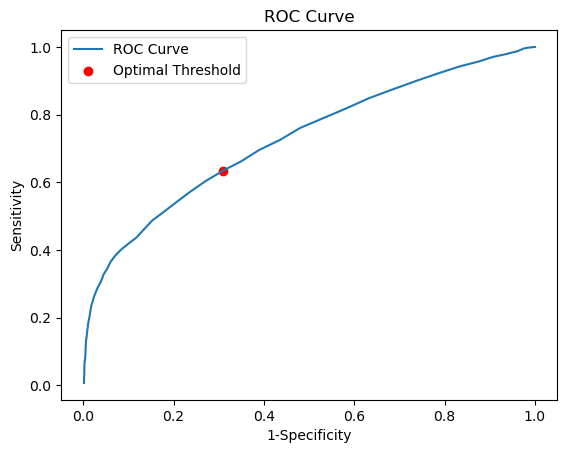

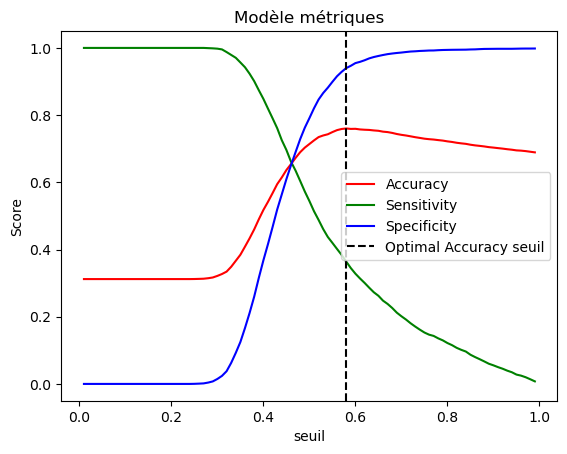

les seuils sont  :  [0.5800000000000001, 0.46, 0.47000000000000003]


In [304]:
def print_results(model):
    seuils = np.arange(0.01, 1.0, 0.01)
    acc_model, sens_model, spec_model, one_minus_spec_model = [], [], [], []
    for i in seuils:
        r = model_evaluation(model, i)
        acc_model.append(r['Classification Score'])
        sens_model.append(r['Model Sensitivity'])
        spec_model.append(r['Model Specificity'])
        one_minus_spec_model.append(1 - r['Model Specificity'])
    
    # Créer un DataFrame pour les résultats
    metriques = pd.DataFrame({
        'seuil': seuils,
        'Accuracy': acc_model,
        'Sensitivity': sens_model,
        'Specificity': spec_model,
        '1-Specificity': one_minus_spec_model
    })
    
    # Trouver le seuil optimal selon différents critères
    optimal_acc = metriques.loc[metriques['Accuracy'].idxmax()]
    optimal_sens_spec = metriques.iloc[(metriques['Sensitivity'] - metriques['Specificity']).abs().idxmin()]
    metriques['Distance_to_Perfect'] = np.sqrt(metriques['1-Specificity']**2 + (1 - metriques['Sensitivity'])**2)
    optimal_roc = metriques.loc[metriques['Distance_to_Perfect'].idxmin()]

    print("Seuil optimal pour maximiser Accuracy:")
    print(optimal_acc)
    print("\nSeuil optimal pour équilibrer Sensibilité et Spécificité:")
    print(optimal_sens_spec)
    print("\nSeuil optimal basé sur la distance au point parfait (ROC):")
    print(optimal_roc)
    
    # Courbe ROC
    plt.figure()
    plt.plot(metriques['1-Specificity'], metriques['Sensitivity'], label='ROC Curve')
    plt.scatter(optimal_roc['1-Specificity'], optimal_roc['Sensitivity'], color='red', label='Optimal Threshold')
    plt.xlabel('1-Specificity')
    plt.ylabel('Sensitivity')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    # Courbes des métriques
    plt.figure()
    plt.plot(metriques['seuil'], metriques['Accuracy'], label='Accuracy', color='red')
    plt.plot(metriques['seuil'], metriques['Sensitivity'], label='Sensitivity', color='green')
    plt.plot(metriques['seuil'], metriques['Specificity'], label='Specificity', color='blue')
    plt.axvline(optimal_acc['seuil'], color='black', linestyle='--', label='Optimal Accuracy seuil')
    plt.xlabel('seuil')
    plt.ylabel('Score')
    plt.legend()
    plt.title('Modèle métriques')
    plt.show()
    
    optimale_seuil = [
        optimal_acc['seuil'],   # Seuil pour Accuracy
        optimal_sens_spec['seuil'],  # Seuil pour équilibrer Sensibilité et Spécificité
        optimal_roc['seuil']    # Seuil basé sur la distance au point parfait (ROC)
    ]
    
    print("les seuils sont  : " , optimale_seuil)
    

    
    
print_results(clf)


### 🧠 <span style="text-decoration: underline;">**Random Forest :**


Le Random Forest ou la forêt aléatoire est un ensemble d'arbres de décision utilisés pour prédire une probabilité (la probabilité d'avoir un retard).Chaque arbre de décision dans la forêt fait une prédiction de probabalité , et la forêt aléatoire combine ces prédictions pour obtenir un résultat final un peu plus robuste et précis.

Un arbre de décision (binaire) est une structure descendante qui a des nœuds et des branches. À chaque nœud, une condition  bien definis va nous permettre de nous diriger dans l'arbre, jusqu'à arriver à la fin de l'arbre.

#### Division de la base de donnée ####

Nous allons procéder de la même manière que pour la régression logistique, en équilibrant les deux classes 0 et 1.

In [319]:
X= df.drop(columns=['Retard'])
y = df['Retard']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Sous-échantillonnage
rus = RandomUnderSampler(random_state=seed)
train_undersampled, train_undersampled_labels = rus.fit_resample(X_train,y_train)
train_undersampled_test, train_undersampled_labels_test = rus.fit_resample(X_test,y_test)


# Sur-échantillonnage
ros = RandomOverSampler(random_state=seed)
train_oversampled, train_oversampled_labels = ros.fit_resample(X_train,
                                                                 y_train)
train_oversampled_test, train_oversampled_labels_test = ros.fit_resample(X_test,y_test)



#### Création du modèle ####

Nous allons fixer  random_state=42 et le nombre de arbres de décision =1000. 

In [323]:
Rand_Fore = RandomForestClassifier(n_estimators=100, random_state=42,class_weight='balanced')
Rand_Fore.fit(train_oversampled, train_oversampled_labels)
y_pred = Rand_Fore.predict(train_oversampled_test)
print("Accuracy:", accuracy_score(train_oversampled_labels_test, y_pred))


Accuracy: 0.7162070304913576


Rapport de Classification :
               precision    recall  f1-score   support

         0.0       0.65      0.93      0.77     10298
         1.0       0.88      0.50      0.64     10298

    accuracy                           0.72     20596
   macro avg       0.77      0.72      0.70     20596
weighted avg       0.77      0.72      0.70     20596



Text(50.722222222222214, 0.5, 'valeurs réelles')

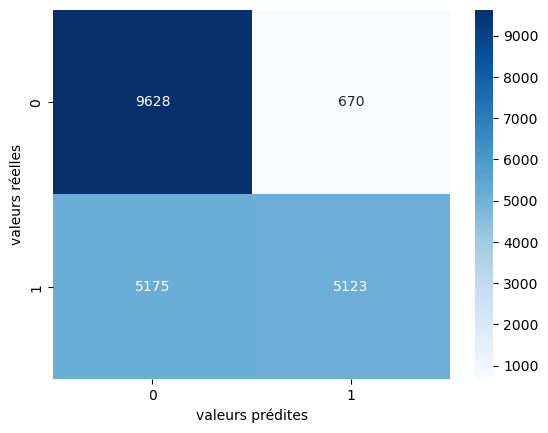

In [324]:
#Les métriques :Précision  Rappel  F1-Score 
 
print("Rapport de Classification :\n", classification_report(train_oversampled_labels_test, y_pred))

#matrice de confusion 
sns.heatmap(confusion_matrix(train_oversampled_labels_test, y_pred), annot=True, fmt='d', cmap='Blues')

plt.xlabel('valeurs prédites')
plt.ylabel('valeurs réelles')


In [307]:
feature_importances = Rand_Fore.feature_importances_
features = df.drop(columns=['Retard']).columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)
print(importance_df)


                                     Feature  Importance
1                    Delay Carrier (Minutes)    0.181634
5      Delay Late Aircraft Arrival (Minutes)    0.085434
0                    Taxi-Out time (Minutes)    0.080832
15                    surface_pressure (hPa)    0.067057
10                       temperature_2m (°C)    0.066970
19                     wind_speed_10m (km/h)    0.065733
20                    wind_direction_10m (°)    0.064928
9                        Destination_encoded    0.060406
18             vapour_pressure_deficit (kPa)    0.059232
11                  relative_humidity_2m (%)    0.054167
3   Delay National Aviation System (Minutes)    0.038264
16                           cloud_cover (%)    0.033860
6                     Weekday_Flight_encoded    0.029787
17                       cloud_cover_low (%)    0.028235
14                   weather_code (wmo code)    0.016891
7                             Season_encoded    0.016171
8                         Perio

In [308]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_


Fitting 3 folds for each of 54 candidates, totalling 162 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   8.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   8.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   8.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.8s


KeyboardInterrupt: 